# TWL Side Quest
We've been trying to brainstorm ways to identify what is causing genes to be differentially methylated (areas of plasticity/plastic markers) - had a meeting with Teresa Lee on 04/16 to talk about some ideas 

There's three main plot ideas to help visualize:
1. metaplot
2. coverage plot
3. Euclidean geometry plot

## 0. load libraries 

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## 1. metaplot

scaled position of genes and features - stetch/shrink individual genes/features to all be the same length, and see if there's a similar distribution of methylation for each treatment combination

## 2. coverage plot
For methlyation levels, I was counting methylation as a binary thing (either the CpG is methylated or not), but instead, it might be helpful to look at the sequencing depth/coverage and see if there are patterns that emerge when focusing on specific features (exons, introns, UTRs) within DMGs and in all genes

**desired dataframe:**
each row is a feature, columns include what feature (exon, intron, UTR), what gene that feature is apart of, then sequencing depth for each replicate oyster (n=5 per treatment combo)

**pipeline to do this:**
- counts matrix for exons, introns, UTRs (for all genes and within DMGs) - can use `bedtools multicov`
- metadata df matching features (exons, introns, UTRs) to genes 
- match these up - use ggplot to create dotplot of sequence depth 


### all genes

to be run in command line using `bedtools multicov` (ran as job using script 'generate_matrixAll.txt'):

```exonList='/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/genomic_feature_tracks/CV_exon_sorted.bed'
intronList='/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/genomic_feature_tracks/CV_intron.bed'
utrList='/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/genomic_feature_tracks/CV_exonUTR.bed'
geneList='/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/genomic_feature_tracks/CV_gene_sorted.bed'

input_dir='/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/BEDtools/working_BAM_sequences'
output_dir='/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/' 


```bedtools multicov -bams ${input_dir}/*.bam -bed $exonList > ${output_dir}allExon_multicov.csv
bedtools multicov -bams ${input_dir}/*.bam -bed $intronList > ${output_dir}allIntron_multicov.csv
bedtools multicov -bams ${input_dir}/*.bam -bed $utrList > ${output_dir}allUTR_multicov.csv
bedtools multicov -bams ${input_dir}/*.bam -bed $geneList > ${output_dir}allGene_multicov.csv```

#### load dfs
these dfs are counts of aligned seqs to each gene/gene feature (*not* individual CpGs within the genes/gene features) 

again, this is for ALL genes, not differentially methylated genes

In [3]:
exons <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/allExon_multicov.csv', sep = '\t')
introns <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/allIntron_multicov.csv', sep = '\t')
utr <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/allUTR_multicov.csv', sep = '\t')
gene <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/allGene_multicov.csv', sep = '\t')

need to add oyster names for assigning treatment types

In [8]:
# getting names of the BAM files for each oyster individual
bam_files <- dir(path = "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/BEDtools/working_BAM_sequences/", pattern = "^.*\\.bam$", full.names = FALSE, ignore.case = TRUE, all.files = TRUE)

# clean sample names
bam_files_clean <- gsub("^2018--|-CV_sorted\\.bam$", "", bam_files)
bam_files_clean

[1] "BBB-WBO-B21" "BBB-WBV-B70" "BBO-BBO-B16" "BBO-BBY-B27" "BBO-WBO-B16"
 [6] "BBO-WBV-B64" "BBR-BBB-B50" "BBR-BBG-B38" "BBR-BBY-B26" "BBY-WBG-B42"
[11] "WBB-WBV-W69" "WBG-BBB-W56" "WBG-WBG-W44" "WBO-BBR-W03" "WBO-WBV-W64"
[16] "WBR-BBY-W25" "WBV-WBO-W23" "WBV-WBR-W12" "WBY-BBV-W65" "WBY-BBY-W30"

In [14]:
# function to add sample names to the columns
add_sampleNames <- function(df) {
    colnames(df) <- c('chromosome', 'start', 'stop', bam_files_clean)
    return(df)
    }

In [17]:
introns2 <- add_sampleNames(introns)
exons2 <- add_sampleNames(exons)
utr2 <- add_sampleNames(utr)
gene2 <- add_sampleNames(gene)

**genes**

In [23]:
gene2$start_stop <- paste(gene2$start, gene2$stop, sep = '_')
head(gene2)

,chromosome,start,stop,BBB-WBO-B21,BBB-WBV-B70,BBO-BBO-B16,BBO-BBY-B27,BBO-WBO-B16,BBO-WBV-B64,BBR-BBB-B50,⋯,WBG-BBB-W56,WBG-WBG-W44,WBO-BBR-W03,WBO-WBV-W64,WBR-BBY-W25,WBV-WBO-W23,WBV-WBR-W12,WBY-BBV-W65,WBY-BBY-W30,start_stop
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,NC_035780.1,28961,33324,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,0,0,0,28961_33324
2,NC_035780.1,43111,66897,0,0,0,0,0,0,2,⋯,0,0,0,4,2,0,0,2,0,43111_66897
3,NC_035780.1,85606,95254,8,12,0,0,6,4,0,⋯,1,0,0,4,0,6,0,0,10,85606_95254
4,NC_035780.1,99840,106460,14,4,2,0,6,0,0,⋯,2,0,0,4,0,2,0,0,2,99840_106460
5,NC_035780.1,108305,110077,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,108305_110077
6,NC_035780.1,151859,157536,4,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,151859_157536


In [25]:
gene_long <- gene2 |>
pivot_longer(cols = 4:23, 
             names_to = 'oyster_rep',
            values_to = 'count' ) 

dim(gene_long)
head(gene_long)

[1] 765220      6

chromosome,start,stop,start_stop,oyster_rep,count
<chr>,<int>,<int>,<chr>,<chr>,<int>
NC_035780.1,28961,33324,28961_33324,BBB-WBO-B21,0
NC_035780.1,28961,33324,28961_33324,BBB-WBV-B70,0
NC_035780.1,28961,33324,28961_33324,BBO-BBO-B16,0
NC_035780.1,28961,33324,28961_33324,BBO-BBY-B27,0
NC_035780.1,28961,33324,28961_33324,BBO-WBO-B16,0
NC_035780.1,28961,33324,28961_33324,BBO-WBV-B64,2


In [56]:
meta_df <- gene_long[1:20,] %>%
select(oyster_rep, phase1, phase2)

meta_df <- meta_df %>%
  mutate(
    code = case_when(
      phase1 == "Hypoxic" & phase2 == "Hypoxic" ~ "HH",
      phase1 == "Hypoxic" & phase2 == "Control" ~ "HC",
      phase1 == "Control" & phase2 == "Hypoxic" ~ "CH",
      phase1 == "Control" & phase2 == "Control" ~ "CC",
      TRUE ~ "Unknown"
    ),
    replicate = str_extract(oyster_rep, "\\d+") %>% as.integer()
  ) %>%
mutate(arbitrary_code = paste(code, replicate, sep ='')) %>%
as.data.frame()


meta_df

,oyster_rep,phase1,phase2,code,replicate,arbitrary_code
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,BBB-WBO-B21,Hypoxic,Control,HC,21,HC21
2,BBB-WBV-B70,Hypoxic,Control,HC,70,HC70
3,BBO-BBO-B16,Hypoxic,Hypoxic,HH,16,HH16
4,BBO-BBY-B27,Hypoxic,Hypoxic,HH,27,HH27
5,BBO-WBO-B16,Hypoxic,Control,HC,16,HC16
6,BBO-WBV-B64,Hypoxic,Control,HC,64,HC64
7,BBR-BBB-B50,Hypoxic,Hypoxic,HH,50,HH50
8,BBR-BBG-B38,Hypoxic,Hypoxic,HH,38,HH38
9,BBR-BBY-B26,Hypoxic,Hypoxic,HH,26,HH26


In [55]:
gene_long <- gene_long %>%
  mutate(
    phase1 = ifelse(str_detect(oyster_rep, "^BB"), "Hypoxic", "Control"),
    phase2 = ifelse(str_detect(oyster_rep, "-BB"), "Hypoxic", "Control")
  ) %>%
mutate(treatment = paste(phase1, phase2, sep = ' ')) %>%
as.data.frame()

head(gene_long)

,chromosome,start,stop,start_stop,oyster_rep,count,phase1,phase2,treatment
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
1,NC_035780.1,28961,33324,28961_33324,BBB-WBO-B21,0,Hypoxic,Control,Hypoxic Control
2,NC_035780.1,28961,33324,28961_33324,BBB-WBV-B70,0,Hypoxic,Control,Hypoxic Control
3,NC_035780.1,28961,33324,28961_33324,BBO-BBO-B16,0,Hypoxic,Hypoxic,Hypoxic Hypoxic
4,NC_035780.1,28961,33324,28961_33324,BBO-BBY-B27,0,Hypoxic,Hypoxic,Hypoxic Hypoxic
5,NC_035780.1,28961,33324,28961_33324,BBO-WBO-B16,0,Hypoxic,Control,Hypoxic Control
6,NC_035780.1,28961,33324,28961_33324,BBO-WBV-B64,2,Hypoxic,Control,Hypoxic Control


In [60]:
# add shortened rep name
gene_long2 <- merge(gene_long, meta_df, by = 'oyster_rep')

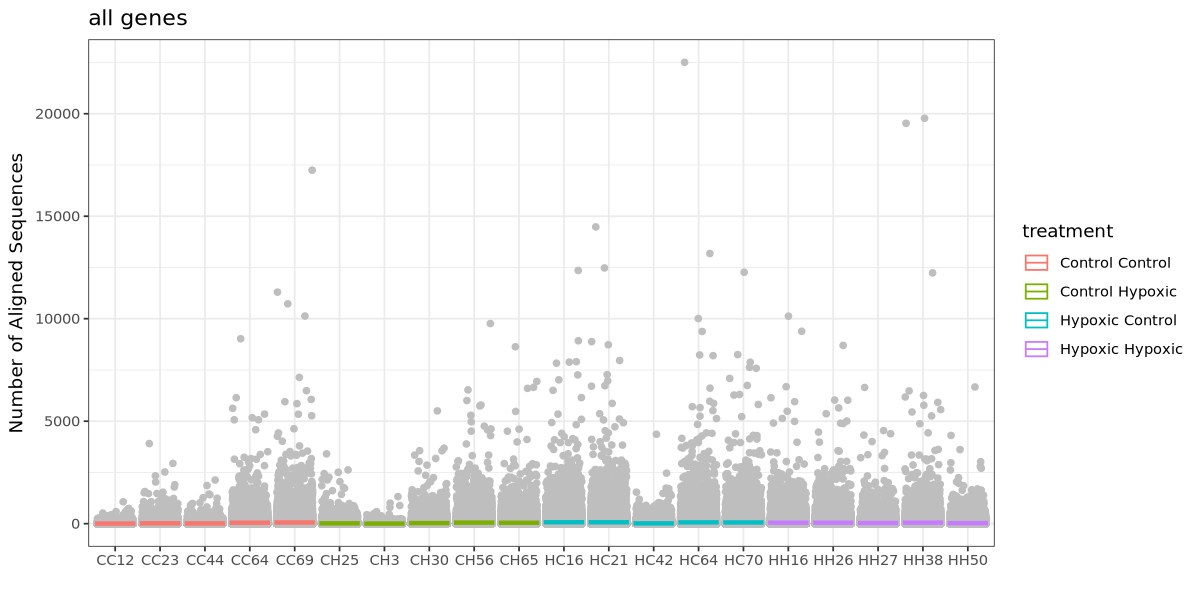

In [76]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(gene_long2, aes(x = arbitrary_code, y = count, colour = treatment)) +
  geom_jitter(color = "gray") +
  stat_summary(fun = "mean", geom = "crossbar") +
labs(x = '', y = 'Number of Aligned Sequences', title = 'all genes') +
guides(fill = 'none') +
  theme_bw()

the average number of sequences for each gene is really low - as seen by the bars at the bottom of the plot

wondering if I should take an average of the counts for each gene within a treatment combo - so instead of having 20 x variables, just have 4, one for each treatment combo (might reduce noise too?)

In [79]:
head(gene_long2)

,oyster_rep,chromosome,start,stop,start_stop,count,phase1.x,phase2.x,treatment,phase1.y,phase2.y,code,replicate,arbitrary_code
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,BBB-WBO-B21,NC_035780.1,28961,33324,28961_33324,0,Hypoxic,Control,Hypoxic Control,Hypoxic,Control,HC,21,HC21
2,BBB-WBO-B21,NC_035783.1,14596993,14610253,14596993_14610253,0,Hypoxic,Control,Hypoxic Control,Hypoxic,Control,HC,21,HC21
3,BBB-WBO-B21,NC_035786.1,38798795,38802017,38798795_38802017,0,Hypoxic,Control,Hypoxic Control,Hypoxic,Control,HC,21,HC21
4,BBB-WBO-B21,NC_035781.1,32898285,32899500,32898285_32899500,0,Hypoxic,Control,Hypoxic Control,Hypoxic,Control,HC,21,HC21
5,BBB-WBO-B21,NC_035784.1,47497685,47524217,47497685_47524217,180,Hypoxic,Control,Hypoxic Control,Hypoxic,Control,HC,21,HC21
6,BBB-WBO-B21,NC_035788.1,12708014,12711392,12708014_12711392,0,Hypoxic,Control,Hypoxic Control,Hypoxic,Control,HC,21,HC21


In [88]:
# collapse gene_long2 into four treatment combos - average count for each gene across replicates within a treatment combo
avg_geneLong <- gene_long2 %>%
  group_by(start_stop, code) %>% # for each gene within treatment combo
  summarise(avg_count = mean(count, na.rm = TRUE)) %>% # calculate average # of sequences 
  ungroup() %>%
mutate(
    phase1 = case_when(
      substr(code, 1, 1) == "C" ~ "Control", # phase 1 is control when first letter is C
      substr(code, 1, 1) == "H" ~ "Hypoxic" # and hypoxic when first letter is H
    ),
    phase2 = case_when(
      substr(code, 2, 2) == "C" ~ "Control", # phase 2 same as above ^
      substr(code, 2, 2) == "H" ~ "Hypoxic"
    ),
    treatment = paste(phase1, phase2, sep = " ") # concatenate phase info for treatment 
  ) %>%
# adding column to designate these are for genes, will merge later on?
mutate(feature = 'gene')

head(avg_geneLong)

`summarise()`
has grouped
output by
'start_stop'.
You can
override using
the `.groups`
argument.


start_stop,code,avg_count,phase1,phase2,treatment,feature
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
100010101_100016587,CC,0.0,Control,Control,Control Control,gene
100010101_100016587,CH,0.0,Control,Hypoxic,Control Hypoxic,gene
100010101_100016587,HC,0.0,Hypoxic,Control,Hypoxic Control,gene
100010101_100016587,HH,0.0,Hypoxic,Hypoxic,Hypoxic Hypoxic,gene
10001514_10009558,CC,5.6,Control,Control,Control Control,gene
10001514_10009558,CH,20.0,Control,Hypoxic,Control Hypoxic,gene


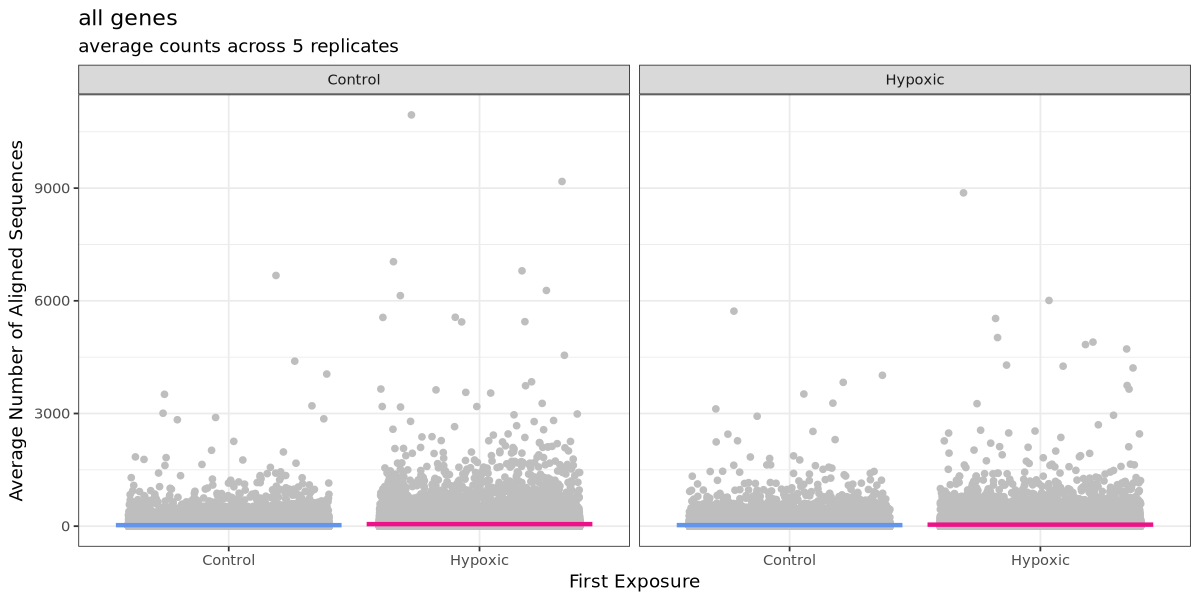

In [87]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(avg_geneLong, aes(x = phase1, y = avg_count, colour = phase1)) +
  geom_jitter(color = "gray") +
facet_wrap(~phase2) + 
  stat_summary(fun = "mean", geom = "crossbar") +
  scale_colour_manual(values=c('cornflowerblue', 'deeppink2')) +
labs(x = 'First Exposure', 
     y = 'Average Number of Aligned Sequences', 
     title = 'all genes', 
     subtitle = 'average counts across 5 replicates') +
guides(colour = 'none') +
  theme_bw()

now to do the same for exons, utrs, introns

#### exons

In [89]:
exon_long <- exons |>
pivot_longer(cols = 4:23, 
             names_to = 'oyster_rep',
            values_to = 'count' ) 

dim(exon_long)
head(exon_long)

[1] 14625560
[2]        5

chromosome,start,stop,oyster_rep,count
<chr>,<int>,<int>,<chr>,<int>
NC_035780.1,14237,14290,BBB-WBO-B21,0
NC_035780.1,14237,14290,BBB-WBV-B70,0
NC_035780.1,14237,14290,BBO-BBO-B16,0
NC_035780.1,14237,14290,BBO-BBY-B27,0
NC_035780.1,14237,14290,BBO-WBO-B16,0
NC_035780.1,14237,14290,BBO-WBV-B64,0


In [91]:
exon_long <- exon_long %>%
  mutate(
    phase1 = ifelse(str_detect(oyster_rep, "^BB"), "Hypoxic", "Control"),
    phase2 = ifelse(str_detect(oyster_rep, "-BB"), "Hypoxic", "Control")
  ) %>%
mutate(treatment = paste(phase1, phase2, sep = ' ')) %>%
as.data.frame()

head(exon_long)

,chromosome,start,stop,oyster_rep,count,phase1,phase2,treatment
,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>
1,NC_035780.1,14237,14290,BBB-WBO-B21,0,Hypoxic,Control,Hypoxic Control
2,NC_035780.1,14237,14290,BBB-WBV-B70,0,Hypoxic,Control,Hypoxic Control
3,NC_035780.1,14237,14290,BBO-BBO-B16,0,Hypoxic,Hypoxic,Hypoxic Hypoxic
4,NC_035780.1,14237,14290,BBO-BBY-B27,0,Hypoxic,Hypoxic,Hypoxic Hypoxic
5,NC_035780.1,14237,14290,BBO-WBO-B16,0,Hypoxic,Control,Hypoxic Control
6,NC_035780.1,14237,14290,BBO-WBV-B64,0,Hypoxic,Control,Hypoxic Control


In [93]:
meta_df <- exon_long[1:20,] %>%
select(oyster_rep, phase1, phase2)

meta_df <- meta_df %>%
  mutate(
    code = case_when(
      phase1 == "Hypoxic" & phase2 == "Hypoxic" ~ "HH",
      phase1 == "Hypoxic" & phase2 == "Control" ~ "HC",
      phase1 == "Control" & phase2 == "Hypoxic" ~ "CH",
      phase1 == "Control" & phase2 == "Control" ~ "CC",
      TRUE ~ "Unknown"
    ),
    replicate = str_extract(oyster_rep, "\\d+") %>% as.integer()
  ) %>%
mutate(arbitrary_code = paste(code, replicate, sep ='')) %>%
as.data.frame()


meta_df

,oyster_rep,phase1,phase2,code,replicate,arbitrary_code
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,BBB-WBO-B21,Hypoxic,Control,HC,21,HC21
2,BBB-WBV-B70,Hypoxic,Control,HC,70,HC70
3,BBO-BBO-B16,Hypoxic,Hypoxic,HH,16,HH16
4,BBO-BBY-B27,Hypoxic,Hypoxic,HH,27,HH27
5,BBO-WBO-B16,Hypoxic,Control,HC,16,HC16
6,BBO-WBV-B64,Hypoxic,Control,HC,64,HC64
7,BBR-BBB-B50,Hypoxic,Hypoxic,HH,50,HH50
8,BBR-BBG-B38,Hypoxic,Hypoxic,HH,38,HH38
9,BBR-BBY-B26,Hypoxic,Hypoxic,HH,26,HH26


In [94]:
# add shortened rep name
exon_long2 <- merge(exon_long, meta_df, by = 'oyster_rep')

In [ ]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(exon_long2, aes(x = arbitrary_code, y = count, colour = treatment)) +
  geom_jitter(color = "gray") +
  stat_summary(fun = "mean", geom = "crossbar") +
labs(x = '', y = 'Number of Aligned Sequences', title = 'all exons') +
guides(colour = 'none') +
  theme_bw()

## 3. Euclidean geometry plot